In [1]:
from pettingzoo.mpe import simple_speaker_listener_v4

In [2]:
env = simple_speaker_listener_v4.env(max_cycles=25, continuous_actions=False, render_mode="rgb_array")

In [3]:
env.reset()

In [4]:
env.agents

['speaker_0', 'listener_0']

In [5]:
for agent in env.agents:
    print(agent, env.observation_space(agent))

speaker_0 Box(-inf, inf, (3,), float32)
listener_0 Box(-inf, inf, (11,), float32)


## Observation Space
**Speaker's Observation Space (`Box(-inf, inf, (3,), float32)`):**

The speaker's observation is a 3-dimensional vector comprising:

1. **Goal Color**: A 3-element array representing the RGB color of the target landmark. This information is crucial for the speaker to identify and communicate the correct landmark to the listener.

**Listener's Observation Space (`Box(-inf, inf, (11,), float32)`):**

The listener's observation is an 11-dimensional vector consisting of:

1. **Self Velocity**: A 2-element array indicating the listener's current velocity in the environment.
2. **Relative Positions of All Landmarks**: Three 2-element arrays (totaling 6 elements) representing the positions of each landmark relative to the listener's current position.
3. **Communication from Speaker**: A 3-element array containing the message sent by the speaker, which typically encodes the target landmark's color. 

In [6]:
for agent in env.agents:
    print(agent, env.action_space(agent))

speaker_0 Discrete(3)
listener_0 Discrete(5)


## Action Space
In the PettingZoo environment `simple_speaker_listener_v4`, the action spaces for the agents are defined as follows:

**Speaker's Action Space (`Discrete(3)`):**

The speaker has 10 discrete actions, each corresponding to a unique message it can send to the listener. These actions are:

- `say_0`
- `say_1`
- `say_2`

Each action transmits a specific message to the listener, aiding in identifying the target landmark.

**Listener's Action Space (`Discrete(5)`):**

The listener has 5 discrete actions, dictating its movement within the environment:

- `no_action`: Remain stationary.
- `move_left`: Move left.
- `move_right`: Move right.
- `move_down`: Move down.
- `move_up`: Move up.

These actions enable the listener to navigate towards the target landmark based on the speaker's messages.

In [7]:
observation, reward, termination, trunc, info = env.last()
observation

array([0.65, 0.15, 0.15], dtype=float32)

## Speaker's Observation:
In the `simple_speaker_listener_v4` environment, the speaker's observation is represented by the `goal_color`, which is a 3-element array corresponding to the RGB (Red, Green, Blue) values of the target landmark's colour. ([GitHub](https://github.com/Farama-Foundation/PettingZoo/blob/master/pettingzoo/mpe/simple_speaker_listener/simple_speaker_listener.py?utm_source=chatgpt.com))

The array `[0.65, 0.15, 0.15]` signifies:

- **Red component**: 0.65
- **Green component**: 0.15
- **Blue component**: 0.15

This indicates that the target landmark is primarily red in colour. 

In [9]:
env.agent_selection = env.agents[1]
observation, reward, termination, trunc, info = env.last()
observation

array([ 0.        ,  0.        , -0.05328575,  0.4192263 , -0.62044495,
        0.13264017, -1.110282  ,  1.009471  ,  0.        ,  0.        ,
        0.        ], dtype=float32)

## Listener's observation
In the `simple_speaker_listener_v4` environment, the listener's observation is an array comprising:

- **Self Velocity**: The listener's own velocity components.
- **Relative Positions of All Landmarks**: The positions of all landmarks relative to the listener's current position.
- **Communication from the Speaker**: The message or communication received from the speaker agent.

In [10]:
# Reset the environment to its initial state
env.reset()

# Iterate over each agent in the environment
for agent in env.agent_iter():
    # Print the current agent's identifier
    print(f"Agent index: {agent}")
    
    # Retrieve the last observation, reward, termination, truncation, and info for the current agent
    observation, reward, termination, truncation, info = env.last()
    
    # Initialize the action variable
    action = None
    
    # Determine the action to take if the agent is neither terminated nor truncated
    if not (termination or truncation):
        # Assign a default action (e.g., action 0) or implement a policy to select an action
        action = 0  # Replace with a policy-based action selection if available
    
    # Execute the chosen action in the environment
    env.step(action)


Agent index: listener_0
Agent index: listener_0
Agent index: listener_0
Agent index: listener_0
Agent index: listener_0
Agent index: listener_0
Agent index: listener_0
Agent index: listener_0
Agent index: listener_0
Agent index: listener_0
Agent index: listener_0
Agent index: listener_0
Agent index: listener_0
Agent index: listener_0
Agent index: listener_0
Agent index: listener_0
Agent index: listener_0
Agent index: listener_0
Agent index: listener_0
Agent index: listener_0
Agent index: listener_0
Agent index: listener_0
Agent index: listener_0
Agent index: listener_0
Agent index: listener_0
Agent index: listener_0
Agent index: listener_0
Agent index: listener_0
Agent index: listener_0
Agent index: listener_0
Agent index: listener_0
Agent index: listener_0
Agent index: listener_0
Agent index: listener_0
Agent index: listener_0
Agent index: listener_0
Agent index: listener_0
Agent index: listener_0
Agent index: listener_0
Agent index: listener_0
Agent index: listener_0
Agent index: lis

## why only listener here?
The agent_iter() function iterates over agents that are expected to take actions. Since the speaker cannot move and its only action is to send a fixed message, it doesn't require iterative action decisions during the environment's execution. Therefore, agent_iter() primarily yields the listener, who needs to decide on movement actions based on the received communication.

In [12]:
class SpeakerPolicy:
    """Policy class for the Speaker agent in the simple_speaker_listener_v4 environment."""
    
    def __init__(self, world):
        """
        Initializes the SpeakerPolicy with a memory mapping of landmark colors to their indices.
        
        Args:
            world: The environment world object containing landmarks.
        """
        # Create a dictionary mapping each landmark's color (as a string) to its index
        self._goal_memory = {
            str(land.color): idx
            for idx, land in enumerate(world.landmarks)
        }
    
    def predict(self, observation):
        """
        Predicts the optimal action (landmark index) based on the observed goal color.
        
        Args:
            observation: The observed goal color.
        
        Returns:
            The index of the landmark corresponding to the observed goal color.
        """
        # Convert the observation (goal color) to a string to match the keys in _goal_memory
        goal_id = str(observation)
        # Retrieve and return the index of the landmark with the matching color
        return self._goal_memory[goal_id]

In [13]:
class ListenerPolicy:
    """Smart listener: identifies communication channels, 
    decodes them, and navigates towards the given goal."""
    
    def predict(self, observation):
        """
        Policy prediction for the listener.
        Input: 
            - observation: Current environment observation for the listener, 
              including communication and goal positions.
        Output:
            - Optimal action: Encoded movement towards the goal.
        """
        # Extract the last 3 elements of the observation, which represent communication channels
        com_channels = observation[-3:]
        
        # Default goal ID set to 0 (in case no valid communication is detected)
        goal_id = 0
        
        # Identify which communication channel is active (goal identifier)
        goal = np.where(com_channels)[0]
        
        # Check if any goal is communicated
        if goal.size > 0:
            # Extract the goal ID from the active communication channel
            goal_id = int(goal)
        
        # Determine the position of the identified goal from the observation
        goal_pos = observation[(goal_id * 2 + 2):(goal_id * 2 + 4)]
        
        # Decide the axis (x or y) based on which direction is further away
        axis = np.argmax(np.abs(goal_pos))
        
        # If the goal position on the chosen axis is negative, move in the negative direction
        if goal_pos[axis] < 0:
            return axis * 2 + 1  # Encodes movement in the negative direction
        
        # Otherwise, move in the positive direction
        return axis * 2 + 2  # Encodes movement in the positive direction


def policy(observation, agent):
    """
    Policy switcher based on the agent type.
    Input:
        - observation: The agent's observation of the environment.
        - agent: The identifier of the current agent.
    Output:
        - The chosen action based on the agent's policy.
    """
    # If the agent is the speaker, use the SpeakerPolicy to determine the action
    if agent == "speaker_0":
        return speaker_policy.predict(observation)
    
    # Otherwise, use the ListenerPolicy to determine the action
    return listener_policy.predict(observation)


In [14]:
num_episodes = 1  # Set the number of episodes for the environment simulation

# Loop through each episode
for ep in range(num_episodes):
    env.reset()  # Reset the environment to its initial state

    # Initialise the Speaker and Listener policies with their respective configurations
    speaker_policy = SpeakerPolicy(env.env.world)  # Speaker policy based on the environment's world
    listener_policy = ListenerPolicy()  # Listener policy to handle navigation and goal-following

    # Initialise total rewards for each agent to track performance
    total_reward = {agent: 0 for agent in env.agents}

    # Iterate through each agent in the environment using agent iteration
    for agent in env.agent_iter():
        # Retrieve the latest observation, reward, termination, truncation, and additional info for the current agent
        observation, reward, termination, trunc, info = env.last()
        
        # Accumulate the reward for the current agent
        total_reward[agent] += reward

        # Determine the action to take:
        # If the agent's episode has terminated or truncated, no action is taken (action = None).
        # Otherwise, the agent performs action `1` as a placeholder.
        action = None if (termination or trunc) else 1
        
        # Execute the chosen action in the environment
        env.step(action)


In [21]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

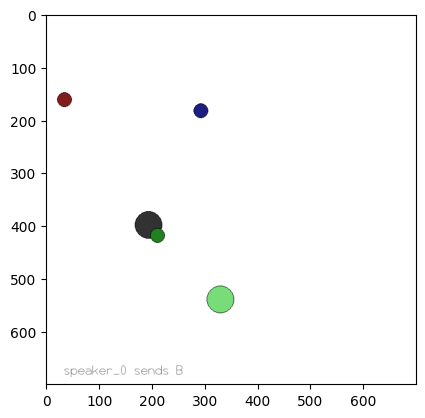

AssertionError: action is not in action space

In [22]:
fig, ax = plt.subplots(figsize=(5, 5))  # Create a figure and axis for displaying the environment's rendering

num_episodes = 1  # Set the number of episodes to simulate

# Loop through each episode
for ep in range(num_episodes):
    env.reset()  # Reset the environment to its initial state

    # Initialise the Speaker and Listener policies
    speaker_policy = SpeakerPolicy(env.env.env.world)  # Initialise the speaker policy using the environment world
    listener_policy = ListenerPolicy()  # Initialise the listener policy for navigation and goal decoding

    # Initialise a dictionary to track total rewards for each agent
    total_reward = {agent: 0 for agent in env.agents}

    # Iterate through each agent in the environment using agent iteration
    for agent in env.agent_iter():
        # Retrieve the latest observation, reward, termination, truncation, and additional info for the current agent
        observation, reward, termination, trunc, info = env.last()
        
        # Accumulate the total reward for the current agent
        total_reward[agent] += reward

        # Determine the action to perform based on the agent's state
        if termination or trunc:
            action = None  # No action is taken if the agent is terminated or truncated
        else:
            # Use the appropriate policy (speaker or listener) to determine the action
            action = (
                speaker_policy.predict(observation)
                if agent == "speaker_0"  # Use the speaker policy if the agent is the speaker
                else listener_policy.predict(observation)  # Use the listener policy otherwise
            )

        # Step the environment forward with the selected action
        env.step(action)

        # Render the current state of the environment
        img = env.render()  # Generate the environment's visual output
        plt.imshow(img)  # Display the rendered image using matplotlib

        # Optional: Update the display in real-time
        # Uncomment plt.show() if running outside of a Jupyter Notebook
        # plt.show()
        clear_output(wait=True)  # Clear the previous frame to display the new one
        plt.pause(0.1)  # Pause for a short duration to simulate animation
